In [1]:
import csv
import numpy
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
%matplotlib inline

In [2]:
# File names
teams_file = "Data//Teams.csv"
ballparks_file = "Data//Ballparks.csv"

path = "Data//Retrosheet//GL"
startyr = 1970
endyr = 2016

In [3]:
# Indicies
# game logs
teamx, vscorex, hscorex, parkx, attx  = 6, 9, 10, 16, 17

# teams_file
yrx, teamidx, gx, home_gx, wx, lx = 0, 2, 6, 7, 8, 9
team_namex, avg_attx = 40, 42

# ballparks
park_namex, capx = 1, 5

In [4]:
def readcsv(fname):
    f = open(fname, 'r')
    reader = csv.reader(f)
    lines = list(reader)
    f.close()
    return lines

In [5]:
class Team:
    def __init__(self, team, teamid, yr, cap):
        self.team = team
        self.teamid = teamid
        self.year = yr
        self.park_capacity = cap
        self.avg_att = 0
        self.att_pct = 0
        self.win_pct = 0
        self.games = []
    def addGame(self, line):
        self.games.append(line)
    def setAvgAtt(self):
        num_games = len(self.games)
        total_att = 0
        for i in range(0, num_games):
            total_att += int(self.games[i][attx])
        self.avg_att = total_att / num_games
    def setAttPct(self):
        num_games = len(self.games)
        actual_att = self.avg_att * num_games
        possible_att = self.park_capacity * num_games
        self.att_pct = actual_att / possible_att
    def win(self, game):
        if game[hscorex] > game[vscorex]:
            return True
        else:
            return False
    def setWinPct(self):
        wins = 0
        num_games = len(self.games)
        for i in range(0, num_games):
            game = self.games[i]
            if self.win(game):
                wins += 1
        self.win_pct = wins / num_games

In [6]:
def build_teamid_ref(lines):
    d = {}
    for line in lines:
        teamid = line[teamidx]
        if teamid not in d:
            d[teamid] = line[team_namex]
    return d

In [7]:
def build_park_ref(lines):
    d = {}
    for line in lines:
        park = line[park_namex]
        if park not in d:
            capacity = line[capx].replace(',','')
            d[park] = int(capacity)
    return d

In [8]:
# builds a dictionary -> {year: {team_name: Team, ...}, ...}
def build_years_dict():
    # create the teamid dictionary for refference
    team_lines = readcsv(teams_file)
    park_lines = readcsv(ballparks_file)
    team_ref = build_teamid_ref(team_lines[1:])
    parks_ref = build_park_ref(park_lines[1:])
    
    years = {}
    for yr in range(startyr, (endyr + 1)):
        # add year to dict and initialize a dict for teams
        years[yr] = {}
        # gather game data for year
        yr_file = path + str(yr) + ".csv"
        games = readcsv(yr_file)
        for game in games:
            # add valid data
            park = game[parkx]
            if park and park in parks_ref:
                if game[attx] and int(game[attx]) > 0:
                        # check if team is in team dict or not
                        teamid = game[teamx]
                        team_name = team_ref[teamid]
                        if team_name not in years[yr]:
                            cap = parks_ref[park]
                            years[yr][team_name] = Team(team_name, teamid, yr, cap)
                        # add game data to proper team
                        years[yr][team_name].addGame(game)

    # set attendance and win percentages
    for yr in years:
        for team in years[yr]:
            t = years[yr][team]
            t.setAvgAtt()
            t.setAttPct()
            t.setWinPct()
    
    return years

In [9]:
def attendancePct_vs_winningPct(years):
    attendancePct = []
    winningPct = []
    for y in years:
        year = years[y]
        for t in year:
            team = year[t]
            attendancePct.append(team.att_pct)
            winningPct.append(team.win_pct)
    # plot the data
    xlabel = "Attendance Percentage"
    ylabel = "Winning Percentage"
    plot_data(attendancePct, winningPct, xlabel, ylabel)

In [10]:
def plot_data(X, Y, xlabel, ylabel):
    fig = plt.figure()
    ax = plt.axes()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    title = ylabel + " VS. " + xlabel
    ax.set_title(title)
    ax.plot(X, Y, '.')
    
    corr = pearsonr(X, Y)
    print("Correlation:", round(corr[0] * 100, 2))

In [11]:
# team_lines = readcsv(teams_file)
# park_lines = readcsv(ballparks_file)
# team_ref = build_teamid_ref(team_lines[1:])
# parks_ref = build_park_ref(park_lines[1:])
# print(parks_ref)

In [12]:
years = build_years_dict()

Correlation: 28.74


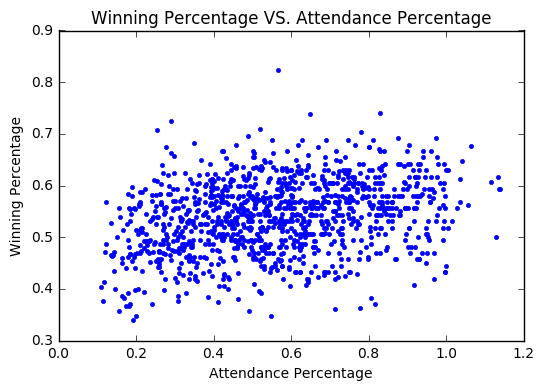

In [13]:
attendancePct_vs_winningPct(years)